# Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from torchvision import datasets, transforms
import torch

from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report



# Set Seed

In [2]:
seed = 13
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
#Data Loader function
"""
def load_training(root_path, dir, batch_size, **kwargs):
    
    Argument: 
    root_path -- root path of the data
    dir       -- train/test/validation directory
    batch_size-- batch size
    
    Returns:
    data_loader       -- data loader from Imagefolder in Pytorch
    data              -- Images dataset
    data.class_to_idx -- maps name of each class to index
    data.classes      -- classes present in the dataset
    
    transform = transforms.Compose(
        [transforms.Resize([256, 256]),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])
    data = datasets.ImageFolder(root=root_path + dir, transform=transform)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=False, **kwargs)
    return data_loader, data, data.class_to_idx, data.classes
"""
def load_training(root_path, dir, transform, batch_size, **kwargs):
    """
    Argument: 
    root_path -- root path of the data
    dir       -- train/test/validation directory
    batch_size-- batch size
    
    Returns:
    data_loader       -- data loader from Imagefolder in Pytorch
    data              -- Images dataset
    data.class_to_idx -- maps name of each class to index
    data.classes      -- classes present in the dataset
    """
    #transform = transforms.Compose(
     #   [transforms.Resize([256, 256]),
      #   transforms.Grayscale(num_output_channels=1),
       #  transforms.ToTensor()])
    data = datasets.ImageFolder(root=root_path + dir, transform=transform)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=False, **kwargs)
    return data_loader, data, data.class_to_idx, data.classes
colors = ['#1f77b4', '#FF4040']

#Plot embedding
def plot_embeddings(embeddings, targets, classes, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(2):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

#Extracts image embeddings from dataloader
def extract_embeddings(dataloader, model, embedding_len):
    """"
    Arguments:
    dataloader -- Dataloader of the images
    model      -- Trained model
    
    Returns:
    embeddings -- resulting embeddings of images from the model
    labels     -- labels of the images/embeddings
    
    """
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), embedding_len))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

def dot(A,B): 
    return (sum(a*b for a,b in zip(A,B)))

def cosine_similarity(a,b):
    return dot(a,b) / ( (dot(a,a) **.5) * (dot(b,b) ** .5)) 

# Prepare dataset

In [4]:
transform_bw = transforms.Compose([transforms.Resize([256, 256]),
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.ToTensor()])
transform_RGB = transforms.Compose([transforms.Resize([256, 256]),
                                   transforms.ToTensor()])


In [5]:
transform = transform_RGB

In [6]:
train_loader, train_data, train_classtoid, train_cl = load_training("/workspace/data/FSL/data1/", "train", transform, 128)
test_loader, test_data, test_classtoid, test_cl = load_training("/workspace/data/FSL/data1/", "test", transform, 128)
flobot_test_loader, flobot_test_data, flobot_test_classtoid, flobot_test_cl = load_training("/workspace/data/FSL/data1/", "test_flobot", transform, 4)
sup1_loader, sup1_data, sup1_classtoid, sup1_cl = load_training("/workspace/data/FSL/data1/", "valid1", transform, 4)
sup2_loader, sup2_data, sup2_classtoid, sup2_cl = load_training("/workspace/data/FSL/data1/", "valid2", transform, 4)
sup3_loader, sup3_data, sup3_classtoid, sup3_cl = load_training("/workspace/data/FSL/data1/", "valid3", transform, 4)
sup4_loader, sup4_data, sup4_classtoid, sup4_cl = load_training("/workspace/data/FSL/data1/", "valid4", transform, 4)

# Prepare CSV for Loader

In [7]:
df_trainlist = pd.DataFrame(train_data.imgs, columns = ['path', 'label'])
df_testlist = pd.DataFrame(test_data.imgs, columns = ['path', 'label'])
df_flobot_testlist = pd.DataFrame(flobot_test_data.imgs, columns = ['path', 'label'])
df_sup1list = pd.DataFrame(sup1_data.imgs, columns = ['path', 'label'])
df_sup2list = pd.DataFrame(sup2_data.imgs, columns = ['path', 'label'])
df_sup3list = pd.DataFrame(sup3_data.imgs, columns = ['path', 'label'])
df_sup4list = pd.DataFrame(sup4_data.imgs, columns = ['path', 'label'])


In [8]:
df_trainlist.to_csv("/workspace/data/FSL/siamese-triplet/csv/train_cust.csv", header= False)
df_testlist.to_csv("/workspace/data/FSL/siamese-triplet/csv/test_cust.csv", header= False)
df_flobot_testlist.to_csv("/workspace/data/FSL/siamese-triplet/csv/flobot_test.csv", header= False)
df_sup1list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup1_cust.csv", header= False)
df_sup2list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup2_cust.csv", header= False)
df_sup3list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup3_cust.csv", header= False)
df_sup4list.to_csv("/workspace/data/FSL/siamese-triplet/csv/sup4_cust.csv", header= False)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [7]:
# Set up data loaders
from datasets import CUHK_train_RGB, CUHK_test_RGB, CUHK_train, CUHK_test

triplet_train_dataset = CUHK_train_RGB("/workspace/data/FSL/siamese-triplet/csv/train_cust.csv", train_data) # Returns triplets of images
triplet_test_dataset = CUHK_test_RGB("/workspace/data/FSL/siamese-triplet/csv/sup1_cust.csv", sup1_data)




batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import TripletNet, EmbeddingNet2_bw, EmbeddingNet2_RGB, EmbeddingNet128_bw, EmbeddingNet128_RGB
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet2_RGB()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3


optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


#cheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 7
log_interval = 100

printing train data length CUHK
8970


# Fit on training dataset

In [8]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)


/workspace/data/FSL/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/8970 (0%)]	Loss: 1.000913
Epoch: 1/7. Train set: Average loss: 2.2894
Epoch: 1/7. Validation set: Average loss: 2.3725
Train: [0/8970 (0%)]	Loss: 0.852599
Epoch: 2/7. Train set: Average loss: 0.6105
Epoch: 2/7. Validation set: Average loss: 1.1632
Train: [0/8970 (0%)]	Loss: 0.432852
Epoch: 3/7. Train set: Average loss: 0.3562
Epoch: 3/7. Validation set: Average loss: 1.8351
Train: [0/8970 (0%)]	Loss: 2.065188
Epoch: 4/7. Train set: Average loss: 0.3652
Epoch: 4/7. Validation set: Average loss: 1.5159
Train: [0/8970 (0%)]	Loss: 1.416160
Epoch: 5/7. Train set: Average loss: 0.2435
Epoch: 5/7. Validation set: Average loss: 1.2400
Train: [0/8970 (0%)]	Loss: 0.555614
Epoch: 6/7. Train set: Average loss: 0.3079
Epoch: 6/7. Validation set: Average loss: 1.5991
Train: [0/8970 (0%)]	Loss: 1.385724
Epoch: 7/7. Train set: Average loss: 0.2551
Epoch: 7/7. Validation set: Average loss: 1.0119


# Generatre embeddings from trained model

In [9]:
emb_len = 2
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model, emb_len)
sup_embeddings_tl, sup_labels_tl = extract_embeddings(sup1_loader, model, emb_len)
test_embeddings_tl, test_labels_tl = extract_embeddings(test_loader, model, emb_len)

In [10]:
test_embeddings_tl.shape

(311, 128)

In [15]:
test_embeddings_tl[0]

array([ 0.11013386,  0.908261  ,  0.36816722, -0.29440123, -0.430316  ,
        0.67036307, -0.38141933, -0.3051061 ,  0.16533037, -0.24438047,
        0.72184807, -0.41571486, -0.08819808,  0.78858727,  0.11553051,
       -0.28867996, -0.57274312,  0.12459302, -0.48935729, -0.29123873,
       -0.54625517,  0.47005001, -0.15409167, -0.41543853, -0.68157458,
       -0.44676691, -0.12945293, -0.19444276, -0.02971957, -0.141341  ,
        0.26034111,  0.5748682 ,  0.45740816, -0.24249768,  0.28991371,
        0.25662127, -0.38379127, -0.39561105, -0.34361187,  0.20514795,
        0.18671268, -0.34680784, -0.4156509 , -0.19744357, -0.51012141,
       -0.27500969,  0.06580673,  0.13963567,  0.79334533,  0.20681882,
       -0.78782207, -0.43495694, -0.01838796, -0.45431229,  0.37095389,
        0.19979382,  0.26524186,  0.10713162,  0.27311635, -0.54161674,
       -0.4526242 , -0.63615614, -0.23342049, -0.29031742,  0.26467934,
        0.26719648, -0.48313075,  0.25425839,  0.13964382, -0.14

# Generate Results

In [11]:
pred = []
pred_ind = []
for i in range(len(test_embeddings_tl)):
    score_list = []
    for j in range(len(sup_embeddings_tl)):
        score = cosine_similarity(test_embeddings_tl[i], sup_embeddings_tl[j])
        score_list.append(score)
    max_ind = score_list.index(max(score_list)) 
    pred_ind.append(max_ind)
    pred.append(sup_labels_tl[max_ind])
    

In [12]:
print("Accuracy: ", accuracy_score(test_labels_tl,pred))
print("f1 Score: ", f1_score(test_labels_tl,pred))
print("Confusion matrix: ", confusion_matrix(test_labels_tl,pred))
print(classification_report(test_labels_tl, pred, labels= [0, 1]))


Accuracy:  0.6141479099678456
f1 Score:  0.6923076923076924
Confusion matrix:  [[ 56  61]
 [ 59 135]]
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       117
           1       0.69      0.70      0.69       194

    accuracy                           0.61       311
   macro avg       0.59      0.59      0.59       311
weighted avg       0.61      0.61      0.61       311



# Plot embeddings

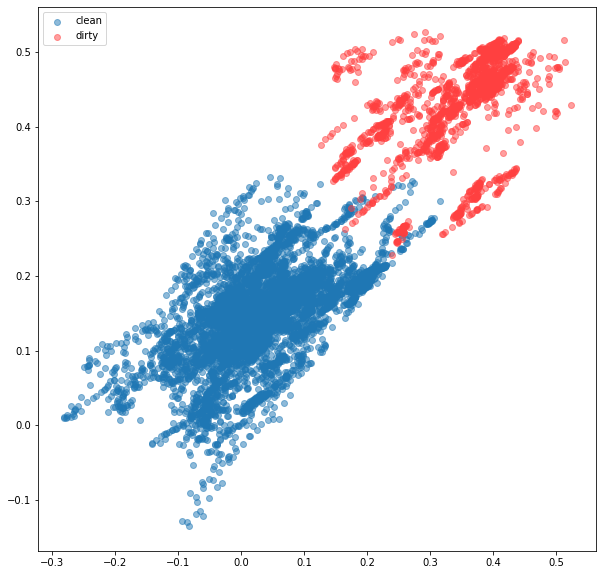

In [16]:
plot_embeddings(train_embeddings_tl, train_labels_tl, train_cl)

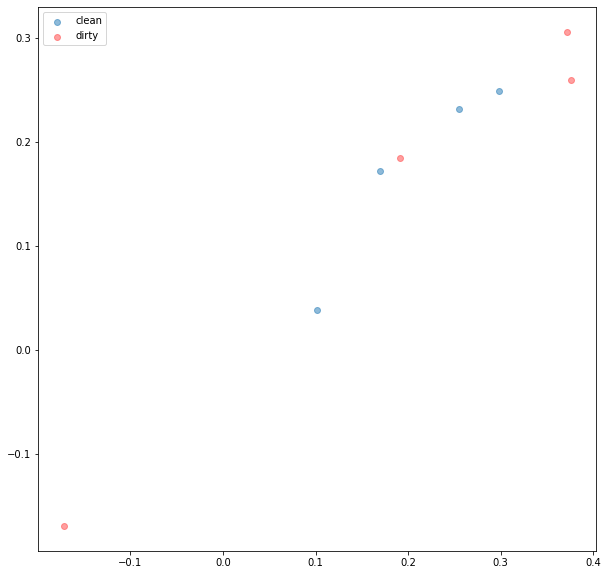

In [17]:
plot_embeddings(sup_embeddings_tl, sup_labels_tl, train_cl)

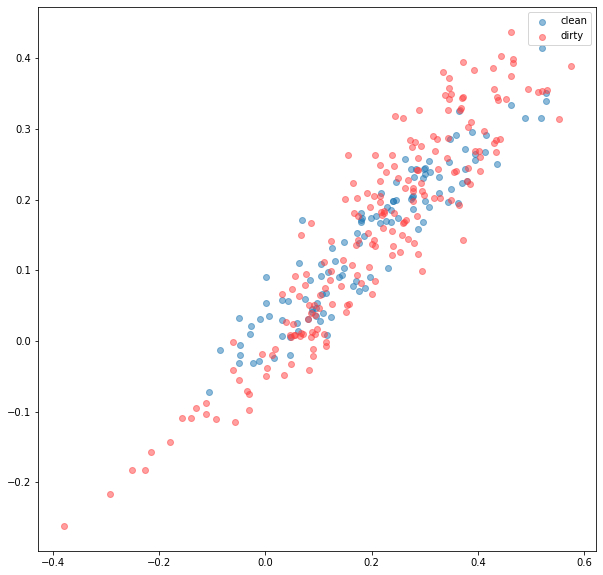

In [18]:
#test_embeddings_tl, test_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(test_embeddings_tl, test_labels_tl, train_cl)